In [1]:
#!pip install validators
#!pip install torch torchvision torchaudio
#!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
#%pip install torchinfo

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd
import gc
import traceback
import random
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
import sklearn.metrics as sm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score   

import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
# Number of workers for dataloader
workers = 8

# Batch size during training
BATCH_SIZE = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
IMAGE_SIZE = 64

# Number of training epochs
NUM_EPOCHS = 1

# Learning rate for optimizers
lr = 0.1

# Beta1 hyperparam for optimizers
beta1 = 0.9

# Beta2 hyperparam for optimizers
beta2 = 0.999


In [4]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [5]:
DATADIR = "BeeMachine_quarter"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [6]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [7]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
                                    std=[0.2403, 0.2280, 0.2248])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]),
}


def load_dataset(transformer):        
    #Load image
    dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
    return dataset


Separate data to train and validation dataset

In [8]:
bee_dataset = load_dataset(data_transforms['train'])

num_classes=len(bee_dataset.targets)
train_indices, val_indices = train_test_split(list(range(num_classes)), test_size=0.2, stratify=bee_dataset.targets)
train_dataset = torch.utils.data.Subset(bee_dataset, train_indices)
val_dataset = torch.utils.data.Subset(bee_dataset, val_indices)
#train_dataset = MyDataset(train_dataset, data_transforms['train'])
#val_dataset = MyDataset(val_dataset, data_transforms['validation'])
resnet50.fc = nn.Sequential(
               nn.Linear(2048, IMAGE_SIZE),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(IMAGE_SIZE, 45),
               nn.Softmax()).to(device) 
torch.autograd.set_detect_anomaly(True)               

Create DataLoader

In [9]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=workers)
print(len(train_dataset))
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=workers)
print(len(val_dataset))
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)

31848
7962


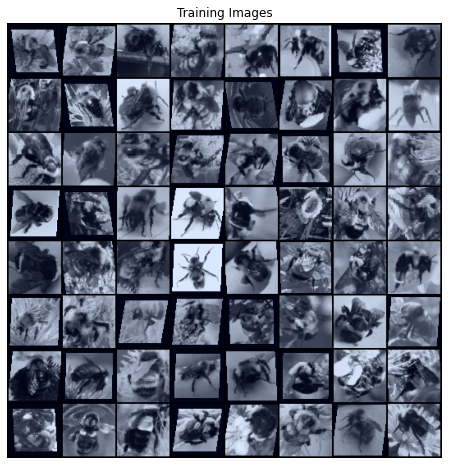

In [10]:
# Plot some training images
real_batch = next(iter(train_data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
weights = class_weight.compute_class_weight('balanced', np.unique(bee_dataset.targets), bee_dataset.targets)
class_weights=torch.tensor(weights,dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=beta1)


In [47]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    
actuals, probabilities = [], []
def process(model, train_loader, test_loader, epochs, lr):
    
    model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    class_weights=torch.tensor(np.unique(bee_dataset.targets),dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(class_weights).cuda()
    optimizer_new = torch.optim.SGD(model.parameters(), lr,
                                momentum=beta1, 
                                weight_decay=1e-4)

    # train & test process
    def train(train_loader, current_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total=0
        targets, preds = [], []
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _,pred = torch.max(output, dim=1)
            correct += torch.sum(pred==target).item()
            total += target.size(0)
            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

            #print('\rTraining %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)
            if (batch_idx) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} \n' 
                    .format(current_epoch, num_epochs, batch_idx, len(train_loader), loss.item()))
            train_acc.append(100 * correct / total)
            train_loss.append(running_loss/total_step)
            
        printMatries(targets, preds)            
       

    def test(test_loader):
        model.eval()
        correct = 0
        total = 0
        batch_loss = 0
        targets, preds = [], []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _,pred = torch.max(output, dim=1)
                actuals.extend(target.view_as(pred).cpu() == 45)
                probabilities.extend(np.exp(output.cpu()[:, 44]))
                correct += torch.sum(pred==target).item()
                
                total += target.size(0)
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())
                
                
        test_acc = 100. * correct / total
        val_acc.append(test_acc)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        displayROC_Curve(actuals, probabilities)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch} \n")
        adjust_learning_rate(optimizer_new, epoch, lr)
        train(train_loader, epoch, epochs)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\nBest test acc = %2.4f%%' % max(test_accs), flush=True)
    labels = [label for _, label in train_data_loader.dataset]
    classe_labels, counts = np.unique(labels, return_counts=True)    
    vis(test_accs, confusion_mtxes, classe_labels)

In [37]:
def printMatries(labels, preds):
     print('F1: {:.4f}'.format(f1_score(labels, preds, average='weighted')))
     print('Precision: {:.4f}'.format(precision_score(labels, preds, average='weighted')))
     print('Recall: {:.4f}'.format(recall_score(labels, preds, average='weighted')))
     print('Accuracy: {:.4f}'.format(accuracy_score(labels, preds)))


In [52]:
def displayROC_Curve(actuals, probabilities):
    fpr, tpr, _ = sm.roc_curve(actuals, probabilities)
    roc_auc = sm.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for digit=%d class' % 45)
    plt.legend(loc="lower right")
    plt.show()

In [53]:
displayROC_Curve(actuals, probabilities)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [14]:
def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

Dataset: 31848 training samples & 7962 testing samples

Distribution of classes in dataset:


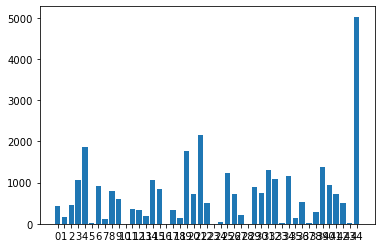

<Figure size 1440x720 with 0 Axes>

In [15]:
print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_data_loader.dataset), len(val_data_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
fig = plt.figure(figsize=(20,10))
labels = [label for _, label in train_dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

In [49]:
try:
    process(resnet50, train_data_loader, val_data_loader, NUM_EPOCHS, lr)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Epoch 1 

Epoch [1/1], Step [0/498], Loss: 3.6063 

Epoch [1/1], Step [100/498], Loss: 3.5644 

Epoch [1/1], Step [200/498], Loss: 3.6458 

Epoch [1/1], Step [300/498], Loss: 3.5027 

Epoch [1/1], Step [400/498], Loss: 3.4759 

F1: 0.0430
Precision: 0.0249
Recall: 0.1578
Accuracy: 0.1578
Traceback (most recent call last):
  File "C:\Users\kuo19\AppData\Local\Temp/ipykernel_35664/3509397903.py", line 2, in <module>
    process(resnet50, train_data_loader, val_data_loader, NUM_EPOCHS, lr)
  File "C:\Users\kuo19\AppData\Local\Temp/ipykernel_35664/488108078.py", line 85, in process
    test_acc, confusion_mtx = test(test_loader)
  File "C:\Users\kuo19\AppData\Local\Temp/ipykernel_35664/488108078.py", line 77, in test
    displayROC_Curve(actuals, probabilities)
  File "C:\Users\kuo19\AppData\Local\Temp/ipykernel_35664/2826947431.py", line 2, in displayROC_Curve
    fpr, tpr, _ = sm.roc_curve(actuals.cpu(), probabilities.cpu())
AttributeError: 'list' object has no attribute 'cpu'

|========

Save Model

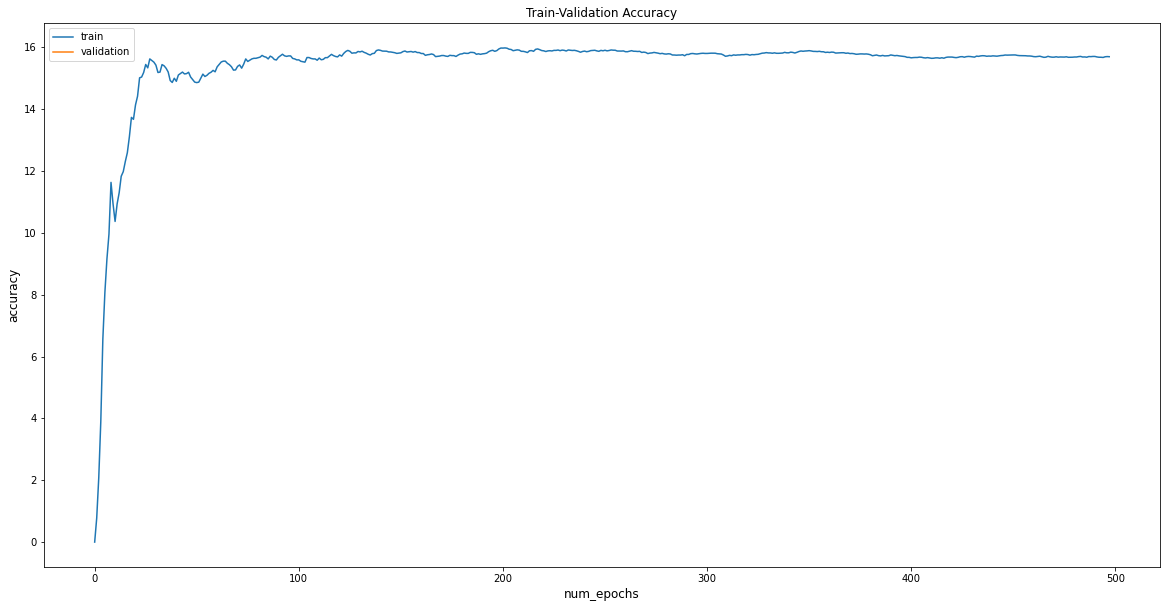

In [17]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

## External Classifier GAN

In [18]:

os.makedirs("images", exist_ok=True)

LEARNING_RATE = 3e-4  # could also use two lrs, one for gen and one for disc
CHANNELS_IMG = 3
NOISE_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
G_losses = []
D_losses = []
cuda = True if torch.cuda.is_available() else False
resnet50_gan = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
resnet50_gan.to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [19]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, (nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [20]:
# Initialize generator and discriminator
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Configure data loader

transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        root=f'{DATADIR}',
        transform=transforms,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion_gan = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

resnet50_gan.fc = nn.Sequential(
               nn.Linear(2048, IMAGE_SIZE),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(IMAGE_SIZE, 45),
               nn.Softmax()).to(device) 

optimizer = optim.SGD(resnet50_gan.fc.parameters(), lr=lr, momentum=beta1)
train_loss = []
train_acc = []
total_step = len(train_dataset)


In [21]:
def training_cgan2(model, n_epochs, dataloader, opt_gen, opt_disc, model_criterion, model_optimizer, train_loss, train_acc, total_step):
    # ----------
    #  Training
    # ----------

    gen.train()
    disc.train()
    model.train()

    for epoch in range(n_epochs):
        realClassifierLoss = None
        fakeClassifierLoss = None
        correct = 0
        total=0
        # Target labels not needed! <3 unsupervised
        for batch_idx, (real, labels) in enumerate(dataloader):
            real = real.to(device)
            labels = labels.to(device)


            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc.zero_grad()
            # train discriminator on real images
            disc_real = disc(real).reshape(-1)
            loss_disc_real = criterion_gan(disc_real, torch.ones_like(disc_real))
            loss_disc_real.backward(retain_graph = True) 

            # train discriminator on fake images
            disc_fake = disc(fake.detach()).reshape(-1)
            loss_disc_fake = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            loss_disc_fake.backward(retain_graph = True) 

            loss_disc = (loss_disc_real + loss_disc_fake)
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            gen.zero_grad()
            disc_fake = disc(fake).reshape(-1)
            loss_gen = criterion_gan(disc_fake , torch.ones_like(disc_fake))
            loss_gen.backward(retain_graph = True)
            opt_gen.step()

            # train classifier on real data
            predictions = model(real)
            realClassifierLoss = model_criterion(predictions, labels)
            realClassifierLoss.backward(retain_graph=True)

            model_optimizer.step()
            model_optimizer.zero_grad()

            _,pred = torch.max(predictions, dim=1)
            correct += torch.sum(pred==labels).item()
            total += labels.size(0)

            # update the classifer on fake data
            predictionsFake = model(fake)
            # get a tensor of the labels that are most likely according to model
            predictedLabels = torch.argmax(predictionsFake, 1) # -> [0 , 5, 9, 3, ...]
            confidenceThresh = .7 # for example

            # psuedo labeling threshold
            probs = F.softmax(predictionsFake, dim=1)
            mostLikelyProbs = np.asarray([probs[i, predictedLabels[i]].item() for  i in range(len(probs))])
            toKeep = mostLikelyProbs > confidenceThresh
            if sum(toKeep) != 0:
                fakeClassifierLoss = model_criterion(predictionsFake[toKeep], predictedLabels[toKeep])
                fakeClassifierLoss.backward()

            model_optimizer.step()

            # reset the gradients
            opt_disc.zero_grad()
            opt_gen.zero_grad()
            model_optimizer.zero_grad()

            # Print losses occasionally and print to tensorboard
            if batch_idx % 50 == 0:
                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                    Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
                )
                if fakeClassifierLoss is not None:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch, NUM_EPOCHS, batch_idx, len(dataloader), fakeClassifierLoss.item()))
            # Save Losses for plotting later
            G_losses.append(loss_gen.item())
            D_losses.append(loss_disc.item())
        
        train_acc.append(100 * correct / total)
        train_loss.append(realClassifierLoss.item()/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

            

In [22]:
training_cgan2(resnet50_gan, NUM_EPOCHS, train_data_loader, opt_gen, opt_disc, criterion, optimizer, train_loss, train_acc, total_step)

Epoch [0/1] Batch 0/498                     Loss D: 1.8417, loss G: 7.9685
Epoch [0/1] Batch 50/498                     Loss D: 0.6189, loss G: 18.5562


KeyboardInterrupt: 

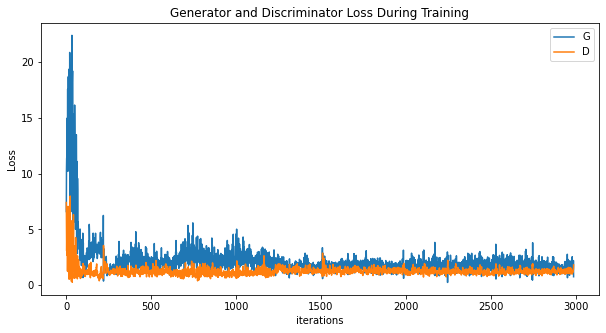

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



## OVER SAMPLEING ## 



In [ ]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

In [ ]:
import argparse
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet50')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [ ]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader

In [ ]:
#weights = class_weight.compute_class_weight(
#    'balanced', np.unique(training_list), training_list)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

#criterion = nn.CrossEntropyLoss(class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
Oversample = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
Oversample.eval().to(device)

In [ ]:
train_loader = train_data_loader
test_loader = val_data_loader

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
        
#!pip install seaborn
import seaborn as sns

print('Dataset:   %d  training samples & %d  testing samples\n' % (
   len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [ ]:
valid_loss_min = np.Inf
y_true = []
y_pred = [] 
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)
num_epochs =3
actuals, probabilities = [], []

#def adjust_learning_rate(optimizer, epoch):
#    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
#    lr = args.lr * (0.1 ** (epoch // 30))
#    for param_group in optimizer.param_groups:
#        param_group['lr'] = lr

def process_Oversample(model, train_loader, test_loader):
#   model = resnet50
    model = torch.nn.DataParallel(model).cuda()

#    model = torchvision.models.__dict__[args.arch]()
#    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
#        model.features = torch.nn.DataParallel(model.features)
#        model.cuda()
#    else:
#        model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            running_loss = 0.0
            optimizer.zero_grad()
            output = model(data)
            outputs = output
            loss = criterion(output, target)
            # Backpropagation.
            loss.backward()
            optimizer.step()         
######## Simon's function
            correct = 0
            total=0
            running_loss += loss.item()
            _,pred = torch.max(output, dim=1)
#           actuals.extend(target.view_as(pred).cpu() == 45)
#           probabilities.extend(np.exp(output.cpu()[:, 44]))
            correct += torch.sum(pred==target).item()
            total += target.size(0)
#           outputs_binary_list = get_outputs_binary_list(
#               outputs.clone().detach().cpu()
#            )
            #print("matrix predict {} target {}".format(pred, target_))
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, num_epochs, batch_idx * batch_size, total_step, loss.item()))
           # y_true.extend(target.detach().cpu().numpy())
           #y_pred.extend(outputs_binary_list)
            train_acc.append(100 * correct / total)
            train_loss.append(running_loss/total_step)
            print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
                
 ##########            
                             
            print('\rTraining       %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)
        
        
        # F1 score    
         #f1_score =calculate_f1_score (y_true, y_pred, average='micro')
         #return epoch_loss, epoch_acc, f1_score    
            #running_loss += loss.item() * inputs.size(0)
            #running_corrects += torch.sum(preds == labels.data)
            # Add these lines to obtain f1_score  
            from sklearn.metrics import f1_score   
            #f1_score = f1_score(labels.data, preds)
        #or: f1_score = f1_score(labels.cpu().data, preds.cpu())   
            

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
 #       displayROC_Curve(actuals, probabilities)

        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], [] 
    
#    for epoch in range(1, args.epochs + 1):
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        correct = 0
        total=0
#       adjust_learning_rate(optimizer, epoch)
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        fig = plt.figure(figsize=(20,10))
        plt.title("Train-Validation Accuracy")
        plt.plot(train_acc, label='train')
        plt.plot(val_acc, label='validation')
        plt.xlabel('num_epochs', fontsize=12)
        plt.ylabel('accuracy', fontsize=12)
        plt.legend(loc='best')
    vis(test_accs, confusion_mtxes, classe_labels)

In [ ]:
process_Oversample (Oversample, train_loader, test_loader)
print(traceback.format_exc())
print(torch.cuda.memory_summary(device=None, abbreviated=False))

## Yelei Test

In [ ]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader

In [ ]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes)) 
weights = torch.DoubleTensor(weights)  
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 500) 
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 7962)                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  

train_data_loader  = train_loader

In [ ]:
process_Oversample (Oversample, train_loader, test_loader)
print(traceback.format_exc())
print(torch.cuda.memory_summary(device=None, abbreviated=False))